In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from glob import glob
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import shapely
import pandas as pd 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sea_clearly.create_masks import get_coastal_nodes

In [33]:
def find_closest_coast(lon, lat):
   
    distance = np.sqrt( ( (lon_coast - lon)*np.cos(lat * (np.pi/180)))**2 + (lat_coast- lat)**2 )

    return indices_lon[mask_coast][np.argmin(distance)], indices_lat[mask_coast][np.argmin(distance)]



data_mask_land = xr.open_dataset('../data/CMEMS_MED_landmask.nc')

mask_land = data_mask_land['mask_land'].values
lons = data_mask_land['lon'].values
lats = data_mask_land['lat'].values
fieldMesh_x,fieldMesh_y = np.meshgrid(lons,lats)

mask_coast = get_coastal_nodes(mask_land).astype(bool)

data_rivers = pd.read_csv('../data/Meijer_rivers.csv')
mask = (data_rivers['lon'] > lons.min()) & (data_rivers['lon'] < lons.max()) & (data_rivers['lat'] > lats.min()) & (data_rivers['lat'] < lats.max())

data_rivers = data_rivers.loc[mask]
lon_river = data_rivers['lon'].values
lat_river = data_rivers['lat'].values
output_river = data_rivers['output [tonnes/year]']

input_matrix_rivers = np.zeros(mask_coast.shape)

lon_coast = fieldMesh_x[mask_coast]
lat_coast = fieldMesh_y[mask_coast]
indices_lon,indices_lat = np.meshgrid(np.arange(len(lons)),np.arange(len(lats)))

for i1, (lon_,lat_,output_) in enumerate(zip(lon_river,lat_river,output_river)):
    
    i_lon, i_lat = find_closest_coast(lon_,lat_)    
    
    input_matrix_rivers[i_lat,i_lon] += output_
    
    if i1 % 100 == 0:
        print('%i/%i' % (i1,len(lon_river)))
        

0/1589
100/1589
200/1589
300/1589
400/1589
500/1589
600/1589
700/1589
800/1589
900/1589
1000/1589
1100/1589
1200/1589
1300/1589
1400/1589
1500/1589


/tmp/ipykernel_3575519/3537167536.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(input_matrix_rivers))


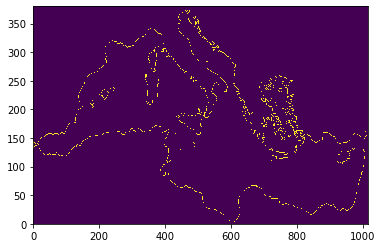

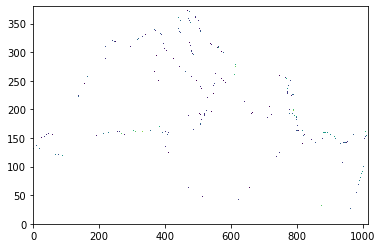

In [34]:
plt.pcolormesh(mask_coast)

plt.figure()
plt.pcolormesh(np.log10(input_matrix_rivers))

In [11]:
data_rivers

,Unnamed: 0,lon,lat,output [tonnes/year]
0,0,168.797917,-46.580833,0.164904
1,1,168.348750,-46.447083,0.124932
2,2,168.337083,-46.418750,1.213370
3,3,168.021250,-46.357917,0.121138
4,4,169.811250,-46.343750,0.197533
...,...,...,...,...
31814,31814,158.641250,53.026250,3.937440
31815,31815,158.488750,53.029583,3.821710
31816,31816,158.612917,53.051250,9.836130
31817,31817,158.532083,53.067917,1.693040


In [37]:
from sea_clearly.write_tools import to_netcdf
to_netcdf('../data/riverine_input.nc',[input_matrix_rivers],['input_rivers'],lons,lats,explanation='riverine input in tonnes/year')